In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("signnteam/asl-sign-language-pictures-minus-j-z")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\remir\.cache\kagglehub\datasets\signnteam\asl-sign-language-pictures-minus-j-z\versions\1


In [2]:
data = "C:/Users/remir/.cache/kagglehub/datasets/signnteam/asl-sign-language-pictures-minus-j-z/versions/1/asl_dataset"

import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

In [3]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

def extract_landmarks(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_image)
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        return [(lm.x, lm.y, lm.z) for lm in landmarks.landmark]
    return None  

dataset_dir = data
output_data = []
labels = []

for class_dir in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_dir)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            landmarks = extract_landmarks(image_path)
            if landmarks is not None:
                output_data.append(np.array(landmarks).flatten())
                labels.append(class_dir)

output_df = pd.DataFrame(output_data)
output_df['label'] = labels
output_df.to_csv("landmarks_dataset.csv", index=False)

Précision: 0.9437570303712036


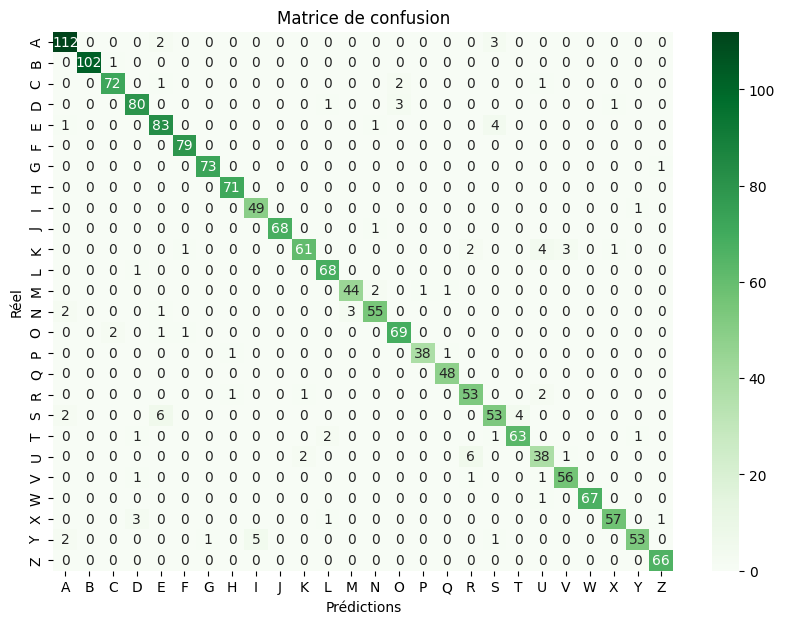

Fonction de coût: 0.40730305940053774


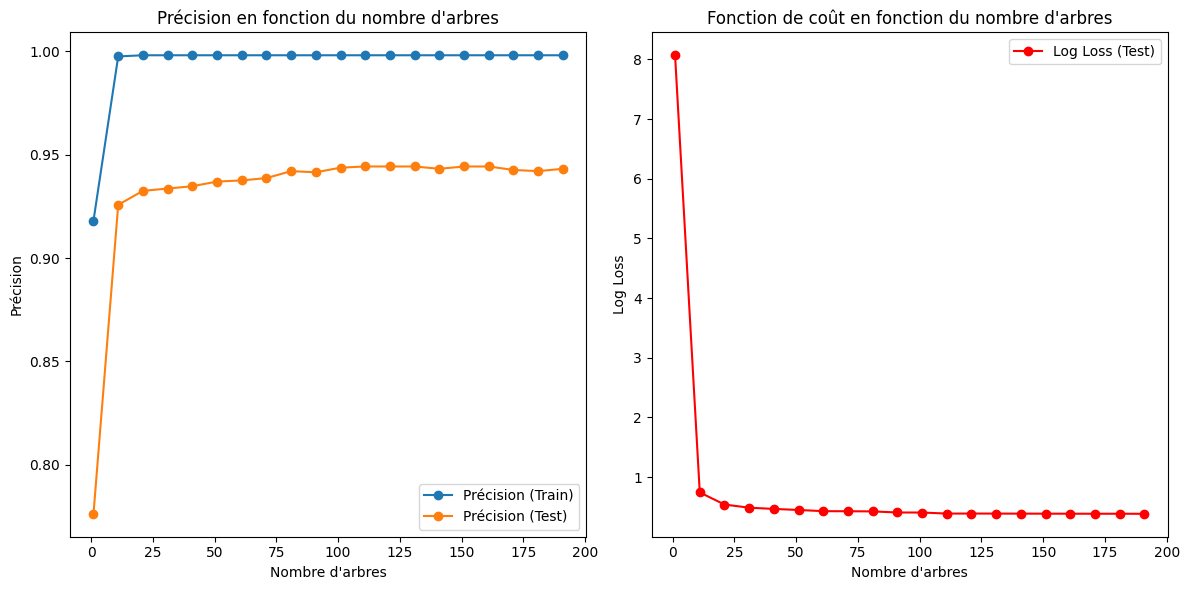

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("landmarks_dataset.csv")
X = data.iloc[:, :-1]  
y = data['label']     

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)
print("Précision:", accuracy_score(y_test, y_pred))

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.savefig("confusion.png", dpi=300)
plt.show()

loss = log_loss(y_test, y_pred_proba)
print("Fonction de coût:", loss)

n_estimators_range = range(1, 201, 10)  # Tester de 1 à 200 arbres avec un pas de 10
train_accuracies = []
test_accuracies = []
test_losses = []

for n_estimators in n_estimators_range:
    rf_temp = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train, y_train)
    
    # Précision sur les ensembles d'entraînement et de test
    train_accuracies.append(accuracy_score(y_train, rf_temp.predict(X_train)))
    test_preds = rf_temp.predict(X_test)
    test_preds_proba = rf_temp.predict_proba(X_test)
    test_accuracies.append(accuracy_score(y_test, test_preds))
    
    test_losses.append(log_loss(y_test, test_preds_proba))

plt.figure(figsize=(12, 6))

# Précision
plt.subplot(1, 2, 1)
plt.plot(n_estimators_range, train_accuracies, label='Précision (Train)', marker='o')
plt.plot(n_estimators_range, test_accuracies, label='Précision (Test)', marker='o')
plt.title('Précision en fonction du nombre d\'arbres')
plt.xlabel('Nombre d\'arbres')
plt.ylabel('Précision')
plt.legend()

# Log loss
plt.subplot(1, 2, 2)
plt.plot(n_estimators_range, test_losses, label='Log Loss (Test)', marker='o', color='red')
plt.title('Fonction de coût en fonction du nombre d\'arbres')
plt.xlabel('Nombre d\'arbres')
plt.ylabel('Log Loss')
plt.legend()
plt.savefig('arbre.png')

plt.tight_layout()
plt.show()

In [8]:
import joblib

joblib.dump(rf,"random.joblib")

['random.joblib']

In [9]:
import cv2
import mediapipe as mp
import numpy as np

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

roi_width = 175
roi_height = 175
roi_x = 40  
roi_y = 20  

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Impossible de lire la caméra")
        break

    # Region of interest
    start_point = (roi_x, roi_y)
    end_point = (roi_x + roi_width, roi_y + roi_height)
    color = (255, 0, 0)  
    thickness = 2 
    cv2.rectangle(frame, start_point, end_point, color, thickness)

    roi_frame = frame[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]
    rgb_roi_frame = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_roi_frame)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
            features = np.array(landmarks).flatten()

            prediction = rf.predict([features])[0]

            cv2.putText(frame, f"Signe : {prediction}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow('Detection de signes', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()